## Load Data Set

In [1]:
import zipfile
import os
import numpy as np
import pathlib
import pandas as pd
from math import ceil
import tensorflow as tf
import numpy as np
import IPython.display as display
import keras
from keras import backend as K
from matplotlib import pyplot as plt
from keras.utils import to_categorical


print(tf.__version__)


mnist = keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

Using TensorFlow backend.


1.13.1


In [2]:
print(x_train.shape, y_train.shape)
x_train = np.expand_dims(x_train, -1)
y_train = to_categorical(y_train)
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)
(60000, 28, 28, 1) (60000, 10)


In [3]:
def custom_loader():
  BATCH_SIZE = 32

  trainset_size = x_train.shape[0]

  p = 0
  while True:

    idx_from = (p * BATCH_SIZE) % trainset_size

    idx_to = idx_from + BATCH_SIZE

    batch_x = x_train[idx_from: idx_to]
    batch_y = y_train[idx_from: idx_to]
    
    p += 1
  
    yield batch_x, batch_y

In [4]:
custom_gen = custom_loader()
for i in range(3):
  batch_x, batch_y = next(custom_gen)
  print(batch_x.shape, batch_y.shape)

(32, 28, 28, 1) (32, 10)
(32, 28, 28, 1) (32, 10)
(32, 28, 28, 1) (32, 10)


## Model Design

In [6]:
enc_len = 0
age_len = 10
img_shape = (28, 28, 1)
width, height, depth = (28, 28, 1)
img_len = np.prod(img_shape)
latent_dim = enc_len + age_len + img_len
noise_len = 50  # 32 x 32 x 3
input_dim = enc_len + age_len + noise_len
cond_len = enc_len + age_len


def build_discriminator():
    model = keras.Sequential([
        # dense 1
        keras.layers.Dense(256, input_shape=(latent_dim,)),
        keras.layers.Activation(tf.nn.relu),
        
        # dense 2
        keras.layers.Dense(512, input_shape=(latent_dim,)),
        keras.layers.Activation(tf.nn.relu),
        
        # output
        keras.layers.Dense(1),
        keras.layers.Activation(tf.nn.sigmoid),
    ])
    
    # condition
#     c1 = keras.layers.Input(shape=(enc_len,))
    c2 = keras.layers.Input(shape=(age_len,))
    
    # image
    z = keras.layers.Input(shape=img_shape)
    
    # flatten image
    z_flat = keras.layers.Flatten()(z)
    
    # concatenation
    inputs = keras.layers.concatenate([c2, z_flat])
    
    # real or fake
    outputs = model(inputs)
    
    return keras.models.Model([c2, z], outputs)


def build_generator():
    model = keras.Sequential([
        
        # dense 1
        keras.layers.Dense(256, input_shape=(input_dim,)),
        keras.layers.Activation(tf.nn.relu),
        
        # dense 2
        keras.layers.Dense(512, input_shape=(input_dim,)),
        keras.layers.Activation(tf.nn.relu),
        
        # dense 3
        keras.layers.Dense(784),
        keras.layers.Activation(tf.nn.relu),
        
        # reshape 1d to 3d
        keras.layers.Reshape((width, height, depth)),
        
        # output
        keras.layers.Activation(tf.nn.tanh),
    ])
    
    # condition
#     c1 = keras.layers.Input(shape=(enc_len,))
    c2 = keras.layers.Input(shape=(age_len,))
    
    # noise
    x = keras.layers.Input(shape=(noise_len,))

    # concatenation
    inputs = keras.layers.concatenate([c2, x])
    
    # real or fake
    outputs = model(inputs)
    
    return keras.models.Model([c2, x], outputs)


generator = build_generator()
discriminator = build_discriminator()

In [7]:
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 60)           0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 28, 28, 1)    549392      concatenate_3[0][0]              
Total para

In [8]:
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 784)          0           input_8[0][0]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 794)          0           input_7[0][0]                    
                                                                 flatten_2[0][0]                  
__________

## Generative Adversarial Network

In [9]:
GLR = 0.0002  # generator
DLR = 0.0002  # discriminator


discriminator.compile(
    optimizer=keras.optimizers.Adam(DLR, 0.5),
    loss=keras.losses.binary_crossentropy,
    metrics=['accuracy']
)


# condition
# c1 = keras.layers.Input(shape=(enc_len,))
c2 = keras.layers.Input(shape=(age_len,))

# noise
x = keras.layers.Input(shape=(noise_len,))

# freeze discriminator
discriminator.trainable = False

# output
z = generator([c2, x])
out = discriminator([c2, z])

# GAN
gan = keras.models.Model(inputs=[c2, x], outputs=out)

gan.compile(
    optimizer=keras.optimizers.Adam(GLR , 0.5),
    loss=keras.losses.binary_crossentropy,
    metrics=['accuracy'])

In [10]:
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 28, 28, 1)    549392      input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
model_4 (Model)                 (None, 1)            335617      input_9[0][0]                    
          

## Visualization Method

In [11]:
# from google.colab import drive
import os


# drive.mount('/content/gdrive', force_remount=True)

root_path = './'
tgt_pth = os.path.join(root_path, 'visualize_mnist-v14')

if not os.path.exists(tgt_pth):
  os.mkdir(tgt_pth)

In [12]:
def visualizeGAN(e, z_real, z_fake):

    fig, axes = plt.subplots(8, 8, figsize=(40, 36))

    r_real = 0
    r_fake = 0
    for row, axe in enumerate(axes):
        for col, cell in enumerate(axe):
            if row % 2 == 0:
                cell.imshow(z_real[r_real * 8 + col])
            else:
                cell.imshow(z_fake[r_fake * 8 + col])

            cell.axis("off")

        if row % 2 == 0:
            r_real += 1
        else:
            r_fake += 1

    plt.axis("off")
    
    fig.savefig(os.path.join(tgt_pth, '{}.jpg'.format(str(e).zfill(3))))
    
    plt.close()

## Load Batch

In [13]:
def load_noise():
    
    y_true = tf.ones((BATCH_SIZE,))
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allocator_type = 'BFC'
    config.gpu_options.per_process_gpu_memory_fraction = 0.40

    with tf.Session(config=config) as sess:
        tf.initialize_all_variables().run()
        
        # run once
        y_true = y_true.eval()

        while True:
            batch_x, batch_y = next(custom_gen)

            sz = batch_x.shape[0]

            if sz != BATCH_SIZE:
                continue
            
            # fake data
            c2 = tf.cast(batch_y, tf.float32).eval()
            x = tf.random.normal((sz, noise_len,)).eval()
            
            yield c2, x, y_true


def load_batch():
    
    y_fake = tf.zeros((BATCH_SIZE,))
    y_true = tf.ones((BATCH_SIZE,))
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allocator_type = 'BFC'
    config.gpu_options.per_process_gpu_memory_fraction = 0.40

    with tf.Session(config=config) as sess:
        tf.initialize_all_variables().run()
        
        # run once
        y_fake = y_fake.eval()
        y_true = y_true.eval()

        while True:
            batch_x, batch_y = next(custom_gen)

            sz = batch_x.shape[0]

            if sz != BATCH_SIZE:
                continue
            
            # fake data
            c2 = tf.cast(batch_y, tf.float32).eval()
            x = tf.random.normal((sz, noise_len,)).eval()
            z_fake = generator.predict([c2, x])

            # real data
            c2 = tf.cast(batch_y, tf.float32).eval()
            z_real = batch_x
                        
            yield c2, x, z_fake, y_fake, z_real, y_true

## Train Model

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0, Steps: 1, Discriminator Accuracy: %35.94, GAN Accuracy: %90.62
Epoch: 1, Steps: 1, Discriminator Accuracy: %37.50, GAN Accuracy: %100.00
Epoch: 2, Steps: 1, Discriminator Accuracy: %48.44, GAN Accuracy: %100.00
Epoch: 3, Steps: 1, Discriminator Accuracy: %50.00, GAN Accuracy: %100.00
Epoch: 4, Steps: 1, Discriminator Accuracy: %50.00, GAN Accuracy: %100.00
Epoch: 5, Steps: 1, Discriminator Accuracy: %50.00, GAN Accuracy: %100.00
Epoch: 6, Steps: 1, Discriminator Accuracy: %50.00, GAN Accuracy: %100.00
Epoch: 7, Steps: 1, Discriminator Accuracy: %50.00, GAN Accuracy: %100.00
Epoch: 8, Steps: 1, Discriminator Accuracy: %50.00, GAN Accuracy: %100.00
Epoch: 9, Steps: 1, Discriminator Accuracy: %50.00, GAN Accuracy: %100.00
Epoch: 10, Steps: 1, Discriminator Accuracy: %50.00, GAN Accuracy: %100.00
Epoch: 11, Steps: 1, Discriminator Accuracy: %50.00, GAN Accuracy: %93.75
Epoch: 12, Steps: 1, Discriminator Accuracy: %50.00, GAN Accuracy: %90.62
Epoch: 13, Steps: 1, Discriminator Acc

KeyboardInterrupt: 

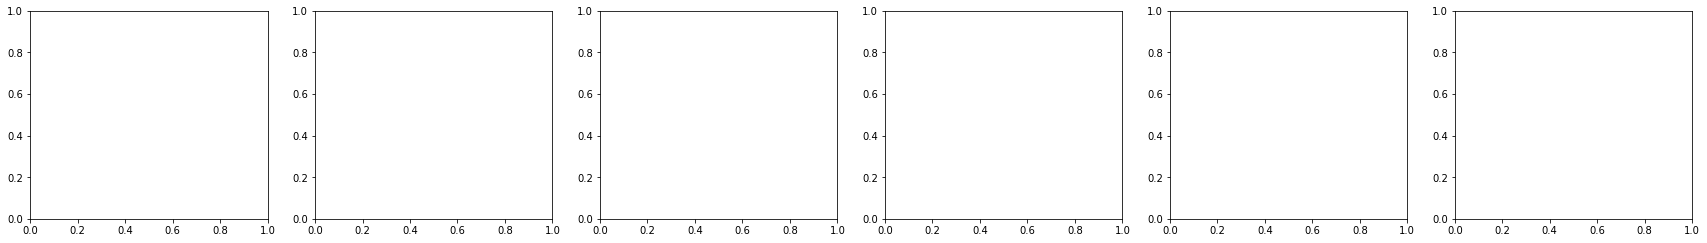

In [14]:
BATCH_SIZE = 32
EPOCHS = 128
STEPS = 1  # 60000 // BATCH_SIZE


train_loss_g = []
train_loss_d = []

train_acc_g = []
train_acc_d = []


disc_itr = load_batch()
gen_itr = load_noise()


# epochs
for e in range(EPOCHS):

    #batches
    loss = []
    acc = []

    for p in range(STEPS * 4):
        
        c2, x, z_fake, y_fake, z_real, y_real = next(disc_itr)
    
        # train
        loss_2, acc_2 = discriminator.train_on_batch([c2, z_real], y_real)
        loss_1, acc_1 = discriminator.train_on_batch([c2, z_fake], y_fake)

        batch_loss = 0.5 * (loss_1 + loss_2)
        batch_acc = 0.5 * (acc_1 + acc_2)

        loss.append(batch_loss)
        acc.append(batch_acc)

    train_loss_d.append(np.mean(np.array(loss)))
    train_acc_d.append(np.mean(np.array(acc)))

    #batches
    loss = []
    acc = []

    for p in range(STEPS):

      c2, x, y_true = next(gen_itr)

      # train
      loss_1, acc_1 = gan.train_on_batch([c2, x], y_true)

      loss.append(loss_1)
      acc.append(acc_1)

    train_loss_g.append(np.mean(np.array(loss)))
    train_acc_g.append(np.mean(np.array(acc)))


    print("Epoch: {}, Steps: {}, Discriminator Accuracy: %{:.2f}, GAN Accuracy: %{:.2f}".format(
          e,
          STEPS,
          train_acc_d[-1] * 100,
          train_acc_g[-1] * 100
      ))

    ## visualize results
    batch_x, batch_y = next(custom_gen)

    sz = batch_x.shape[0]

    # fake data
    #     c1 = row['enc']
    c2 = tf.cast(batch_y, tf.float32).eval()
    x = tf.random.normal((sz, noise_len,)).eval()
    z_fake = generator.predict([c2, x])
    z_fake = np.squeeze(z_fake, axis=-1)

    # real data
    z_real = batch_x
    z_real = np.squeeze(z_real, axis=-1)

    visualizeGAN(e, z_real, z_fake)

## Plot Loss

In [ ]:
plt.figure(figsize=(20, 18))
plt.plot(train_loss_g, label="Generator Loss");
plt.plot(train_loss_d, label="Discriminator Loss");
plt.legend();

## Plot Accuracy

In [ ]:
plt.figure(figsize=(20, 18))
plt.plot(train_acc_g, label="Generator Accuracy");
plt.plot(train_acc_d, label="Discriminator Accuracy");
plt.legend();